# Traditional machine learning models for age prediction on EEG data

This notebook uses traditional ML methods to predict the age of infants using EEG data. The EEG data is preprocessed.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from epodium.config import Config
from epodium.loaders import RegressionsLoader
from epodium.ml import Regressions
from epodium.nn import NnOptimizer

config = Config()

2022-08-13 15:42:52.305637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 15:42:52.305667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load preprocessed data

Steps:

1. Get all the files in the output folder
2. Get the full paths of the files without the .h5 or .csv extensions
3. Load the features from the .h5 files
4. Assign the proper labels to the files based on the metadata
5. Assign the subject's code to the files based on the metadata
6. Split the data into a training, validation and test set (NOTE: make sure data points from same subjects don't end up in same set

In [2]:
def plot_result(df, prop, x, y):
    sns.set()
    ax = sns.scatterplot(x=x, y=y, hue=prop, palette='RdBu', data=df)

    norm = plt.Normalize(df[prop].min(), df[prop].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    ax.figure.colorbar(sm)

    plt.show()

In [3]:
%%time
rloader = RegressionsLoader(config.get_directory('preprocessed'), config.get_directory('models'), samples=100)
rloader.load()
rloader.split()
regressions = Regressions(rloader)

CPU times: user 4.53 s, sys: 1.28 s, total: 5.81 s
Wall time: 6.98 s


## Dummy regressor

Firstly, we make predictions with dummy regressors as a simple baseline to see whether other models learn "something". From the sklearn docs: 

> `DummyRegressor` is a regressor that makes predictions using simple rules. This regressor is useful as a simple baseline to compare with other (real) regressors."

In [4]:
%%time
regressions.algorithms['dummy'].fit()

CPU times: user 1.19 ms, sys: 245 µs, total: 1.44 ms
Wall time: 6.25 ms


DummyRegressor()

In [51]:
score, rmsee, ma, ae =  regressions.algorithms['rf'].predict()

In [52]:
print(score, rmse, mae)

NameError: name 'rmse' is not defined

## Model 1: Random Forest regressor

In [50]:
%%time
regressions.algorithms['rf'].grid_search()

CPU times: user 57.1 s, sys: 382 ms, total: 57.5 s
Wall time: 58.5 s


GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1), n_jobs=1,
             param_grid={'max_features': ['sqrt', 'log2', 15, 30, 40, 50, 60,
                                          70, 80, 90, 100, 150, 250, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10, 20, 30, 40,
                                              50]})

In [51]:
score, rmsee, ma, ae =  regressions.algorithms['rf'].predict()

In [52]:
print(score, rmse, mae)

NameError: name 'rmse' is not defined

In [51]:
score, rmsee, ma, ae =  regressions.algorithms['rf'].predict()

### Train with best parameters

In [6]:
%%time
regressions.algorithms['rf'].fit()

CPU times: user 95.3 ms, sys: 3.76 ms, total: 99 ms
Wall time: 117 ms


RandomForestRegressor(n_jobs=-1)

## Model 2: Linear Support Vector Regressor

There are a lot of training examples in the training set. According to the sklearn docs: "The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples." 

They recommend using a linear SVR for large data sets. Therefore, let's try this first.

### Randomized search

In [7]:
%%time
lsv_result = regressions.algorithms['lsv'].fit()

CPU times: user 239 ms, sys: 53.9 ms, total: 293 ms
Wall time: 8.29 s


In [8]:
cv_df = pd.DataFrame(lsv_result.cv_results_).sort_values('rank_test_score').head(50)
cv_df.head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvr__C,param_linearsvr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
78,0.017515,0.002732,0.005870,0.001553,0.423565,0.06929,"{'linearsvr__C': 0.4235649267357636, 'linearsv...",-0.070788,-0.082138,-0.080751,-0.070121,-0.069651,-0.074690,0.005544,1
16,0.018541,0.001546,0.006070,0.001615,0.363403,0.100583,"{'linearsvr__C': 0.3634030383892165, 'linearsv...",-0.102548,-0.111085,-0.124342,-0.100174,-0.100138,-0.107657,0.009261,2
82,0.020405,0.001807,0.005199,0.001994,0.567815,0.180302,"{'linearsvr__C': 0.5678149210557019, 'linearsv...",-0.182518,-0.192336,-0.176548,-0.179639,-0.179419,-0.182092,0.005459,3
8,0.018903,0.001787,0.006879,0.000069,0.304221,0.193245,"{'linearsvr__C': 0.30422060618934776, 'linears...",-0.192714,-0.214918,-0.194377,-0.193533,-0.192931,-0.197695,0.008631,4
83,0.019328,0.002392,0.005247,0.001948,0.611046,0.276761,"{'linearsvr__C': 0.6110456800268786, 'linearsv...",-0.279170,-0.272227,-0.280159,-0.276178,-0.277201,-0.276987,0.002763,5
91,0.018739,0.001479,0.006834,0.000572,0.91893,0.32881,"{'linearsvr__C': 0.9189300752269004, 'linearsv...",-0.331222,-0.328109,-0.329386,-0.328935,-0.329767,-0.329484,0.001030,6
30,0.025198,0.007269,0.006716,0.000826,0.963329,0.374781,"{'linearsvr__C': 0.963328795527815, 'linearsvr...",-0.374837,-0.372969,-0.366200,-0.373935,-0.374155,-0.372419,0.003166,7
29,0.040400,0.007220,0.013334,0.005464,0.384333,0.388142,"{'linearsvr__C': 0.3843329319493751, 'linearsv...",-0.390648,-0.384776,-0.378102,-0.387510,-0.388587,-0.385925,0.004346,8
1,0.017126,0.001438,0.006025,0.001052,0.757599,0.741564,"{'linearsvr__C': 0.757598689153884, 'linearsvr...",-0.743801,-0.724792,-0.718489,-0.740449,-0.741980,-0.733902,0.010263,9
99,0.015448,0.002883,0.006848,0.003600,0.221532,0.823583,"{'linearsvr__C': 0.22153150048784231, 'linears...",-0.824894,-0.828475,-0.801706,-0.823236,-0.823201,-0.820302,0.009494,10


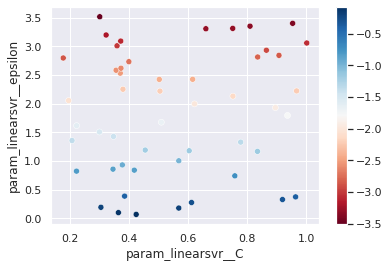

In [9]:
plot_result(cv_df, 'mean_test_score', "param_linearsvr__C", "param_linearsvr__epsilon")

### Grid search

In [10]:
%%time
lsv_gs_result = regressions.algorithms['lsv'].grid_search()

CPU times: user 2.35 s, sys: 143 µs, total: 2.35 s
Wall time: 2.39 s


In [11]:
lsv_gs_result.best_params_

{'linearsvr__C': 0.65, 'linearsvr__epsilon': 1.5}

In [12]:
cv_df_gs = pd.DataFrame(lsv_gs_result.cv_results_).sort_values('rank_test_score').head(50)
cv_df_gs.head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvr__C,param_linearsvr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.009819,0.000493,0.002838,0.000035,0.65,1.5,"{'linearsvr__C': 0.65, 'linearsvr__epsilon': 1.5}",-1.501824,-1.489011,-1.484336,-1.499998,-1.499766,-1.494987,0.006983,1
4,0.009703,0.000171,0.002853,0.000047,0.45,1.5,"{'linearsvr__C': 0.45, 'linearsvr__epsilon': 1.5}",-1.501037,-1.505909,-1.470684,-1.500171,-1.500036,-1.495567,0.012627,2
32,0.009717,0.000238,0.002828,0.000011,0.8,1.5,"{'linearsvr__C': 0.8, 'linearsvr__epsilon': 1.5}",-1.501296,-1.503944,-1.482487,-1.498862,-1.500227,-1.497363,0.007623,3
28,0.009611,0.000234,0.002832,0.000013,0.75,1.5,"{'linearsvr__C': 0.75, 'linearsvr__epsilon': 1.5}",-1.500833,-1.507393,-1.479574,-1.499103,-1.500646,-1.497510,0.009411,4
0,0.010045,0.000538,0.002881,0.000054,0.4,1.5,"{'linearsvr__C': 0.4, 'linearsvr__epsilon': 1.5}",-1.498738,-1.503003,-1.489123,-1.501404,-1.500073,-1.498468,0.004882,5
12,0.009786,0.000150,0.002829,0.000020,0.55,1.5,"{'linearsvr__C': 0.55, 'linearsvr__epsilon': 1.5}",-1.501877,-1.504813,-1.489799,-1.499106,-1.500730,-1.499265,0.005087,6
16,0.009638,0.000235,0.002811,0.000030,0.6,1.5,"{'linearsvr__C': 0.6, 'linearsvr__epsilon': 1.5}",-1.501785,-1.508626,-1.489552,-1.501377,-1.500095,-1.500287,0.006136,7
8,0.009925,0.000346,0.002845,0.000058,0.5,1.5,"{'linearsvr__C': 0.5, 'linearsvr__epsilon': 1.5}",-1.500440,-1.512927,-1.493665,-1.500788,-1.500558,-1.501676,0.006234,8
24,0.009858,0.000445,0.002809,0.000022,0.7,1.5,"{'linearsvr__C': 0.7, 'linearsvr__epsilon': 1.5}",-1.499764,-1.514351,-1.502632,-1.498673,-1.499562,-1.502996,0.005831,9
29,0.009572,0.000297,0.002807,0.000025,0.75,2,"{'linearsvr__C': 0.75, 'linearsvr__epsilon': 2}",-2.001691,-1.990972,-1.988414,-1.999089,-2.000159,-1.996065,0.005330,10


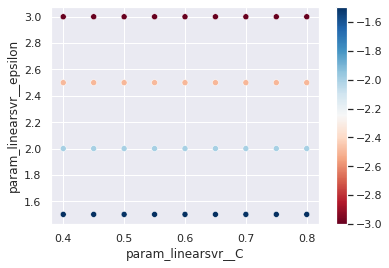

In [13]:
plot_result(cv_df_gs, 'mean_test_score', "param_linearsvr__C", "param_linearsvr__epsilon")

### Train on all data with best parameters

In [14]:
%%time
regressions.algorithms['lsv'].best_fit()

CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 16.6 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(C=0.45, epsilon=2.5, max_iter=50000))])

In [ ]:
regressions

## Model 3: (Non-linear) Support Vector Regressor

Let's try fitting a SVR on a (small) chunk of the training data. The parameter search below is quite small, but a broader search has been done before. However, a more fine-grained search is still necessary. The downside of SVR with a non-linear kernel is that it's very slow to fit and predict.

### Randomized search

In [15]:
%%time
nl_srv_result = regressions.algorithms['svr'].fit()

CPU times: user 218 ms, sys: 8.91 ms, total: 227 ms
Wall time: 4.83 s


In [16]:
nl_srv_result.best_params_

{'svr__C': 32.14746284438403,
 'svr__epsilon': 5.7292348184913875,
 'svr__gamma': 0.004410519851895524}

In [17]:
df_rs_svr = pd.DataFrame(nl_srv_result.cv_results_).sort_values('rank_test_score')
df_rs_svr = df_rs_svr.loc[df_rs_svr['param_svr__gamma'] < 0.0025].head(20)
df_rs_svr.head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
70,0.011346,0.002194,0.004378,0.001981,37.890132,2.98047,0.00111,"{'svr__C': 37.890131885702836, 'svr__epsilon':...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
60,0.013071,0.003052,0.005177,0.001970,1.919649,0.505218,0.001839,"{'svr__C': 1.9196485577253408, 'svr__epsilon':...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
59,0.014409,0.005000,0.004415,0.001983,21.52405,1.494566,0.0017,"{'svr__C': 21.524049633964907, 'svr__epsilon':...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
52,0.011631,0.004072,0.006000,0.003010,23.719768,2.120738,0.000051,"{'svr__C': 23.71976800202095, 'svr__epsilon': ...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
73,0.011566,0.003226,0.005978,0.001623,45.349215,0.829277,0.001643,"{'svr__C': 45.34921535395516, 'svr__epsilon': ...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
89,0.012353,0.001939,0.004380,0.001983,25.58287,3.347545,0.0011,"{'svr__C': 25.582869891533914, 'svr__epsilon':...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
86,0.011242,0.002287,0.006817,0.002589,36.224788,5.066544,0.002257,"{'svr__C': 36.224788067559956, 'svr__epsilon':...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
83,0.011548,0.001965,0.005983,0.001609,39.991206,0.266893,0.001354,"{'svr__C': 39.99120573969038, 'svr__epsilon': ...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
79,0.013139,0.002891,0.004052,0.001644,8.68891,1.626995,0.000454,"{'svr__C': 8.688910280161439, 'svr__epsilon': ...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
50,0.014283,0.002982,0.006031,0.003483,21.239526,3.321311,0.00046,"{'svr__C': 21.239525895836074, 'svr__epsilon':...",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1


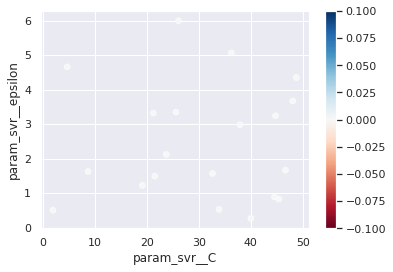

In [18]:
plot_result(df_rs_svr, 'mean_test_score', 'param_svr__C', 'param_svr__epsilon')

<AxesSubplot:xlabel='param_svr__gamma', ylabel='mean_test_score'>

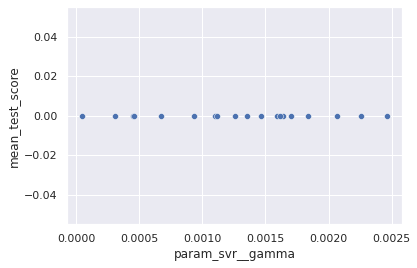

In [19]:
sns.scatterplot(x="param_svr__gamma", y="mean_test_score", data=df_rs_svr)

### Grid search

In [20]:
%%time
svr_gs_result = regressions.algorithms['svr'].grid_search()

CPU times: user 7.98 s, sys: 3.7 ms, total: 7.98 s
Wall time: 8.05 s


In [21]:
svr_gs_result.best_params_

{'svr__C': 10, 'svr__epsilon': 1}

In [22]:
df_gs_svr = pd.DataFrame(svr_gs_result.cv_results_).sort_values('rank_test_score')
df_gs_svr.head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006380,0.000322,0.002913,0.000117,10,1,"{'svr__C': 10, 'svr__epsilon': 1}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
108,0.006051,0.000033,0.002783,0.000032,35,5,"{'svr__C': 35, 'svr__epsilon': 5}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
109,0.006028,0.000019,0.002779,0.000023,35,5.5,"{'svr__C': 35, 'svr__epsilon': 5.5}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
110,0.006023,0.000013,0.002767,0.000009,37.5,1,"{'svr__C': 37.5, 'svr__epsilon': 1}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
111,0.006017,0.000026,0.002782,0.000026,37.5,1.5,"{'svr__C': 37.5, 'svr__epsilon': 1.5}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
112,0.006104,0.000031,0.002794,0.000018,37.5,2,"{'svr__C': 37.5, 'svr__epsilon': 2}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
113,0.006111,0.000040,0.002923,0.000193,37.5,2.5,"{'svr__C': 37.5, 'svr__epsilon': 2.5}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
114,0.006258,0.000199,0.002901,0.000165,37.5,3,"{'svr__C': 37.5, 'svr__epsilon': 3}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
115,0.006105,0.000076,0.002826,0.000041,37.5,3.5,"{'svr__C': 37.5, 'svr__epsilon': 3.5}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1
116,0.006108,0.000032,0.002854,0.000060,37.5,4,"{'svr__C': 37.5, 'svr__epsilon': 4}",-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1


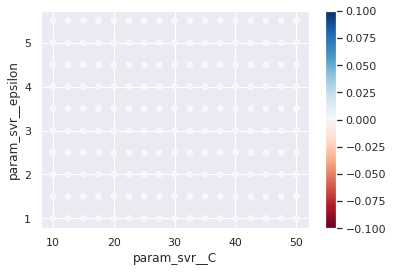

In [23]:
plot_result(df_gs_svr, 'mean_test_score', 'param_svr__C', 'param_svr__epsilon')

### Train with best parameters

In [24]:
%%time
svr_result = regressions.algorithms['svr'].best_fit()

CPU times: user 5.06 ms, sys: 3.89 ms, total: 8.96 ms
Wall time: 13.1 ms


## Model 4: SGD Regressor

Inschatting tijd, mijn computer:
    
- X min voor een SGD (1 configuratie)
- RandomizedSearch: 250 iteraties, 5 folds per iteratie = 1250
- 1250 SGD * X = X uur (Schatting met mijn 1 core)

Memory usage:
- X GB per core?

Fitting a SVR is computationally expensive. Therefore, we try prediction with an SGD Regressor. According to the sklearn documentation, it's best to start with a RandomizedSearchCV to find reasonable hyperparameters. Therefore, we start with this.

### Randomized search

In [25]:
%%time
sgd_result = regressions.algorithms['sgd'].fit()

CPU times: user 2.89 s, sys: 70.9 ms, total: 2.96 s
Wall time: 1min 21s


In [26]:
sgd_result.best_params_

{'sgdregressor__alpha': 0.0013276914704488652,
 'sgdregressor__epsilon': 2.6271641972797455,
 'sgdregressor__loss': 'huber'}

In [27]:
df_rs_sgd = pd.DataFrame(sgd_result.cv_results_).sort_values('rank_test_score')
df_rs_sgd = df_rs_sgd.loc[
    df_rs_sgd['param_sgdregressor__loss'] == 'huber'
].sort_values('rank_test_score').head(5000)
df_rs_sgd.head(60)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdregressor__alpha,param_sgdregressor__epsilon,param_sgdregressor__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
387,0.024860,0.003256,0.005211,0.002005,0.001328,2.627164,huber,"{'sgdregressor__alpha': 0.0013276914704488652,...",-0.034041,-0.044766,-0.209490,-0.024711,-0.022459,-0.067093,0.071633,1
831,0.021176,0.003390,0.006025,0.001629,0.003543,3.545493,huber,"{'sgdregressor__alpha': 0.003542757020117311, ...",-0.186704,-0.137503,-0.242122,-0.038721,-0.032718,-0.127554,0.081986,2
811,0.022436,0.003453,0.004770,0.002494,0.002951,3.199228,huber,"{'sgdregressor__alpha': 0.0029512428142435673,...",-0.045891,-0.361491,-0.208863,-0.024174,-0.019686,-0.132021,0.134335,3
54,0.022424,0.003377,0.007221,0.002633,0.002718,2.901427,huber,"{'sgdregressor__alpha': 0.002718237681593224, ...",-0.059921,-0.128536,-0.381380,-0.041076,-0.081051,-0.138393,0.124945,4
140,0.021113,0.002403,0.008453,0.003238,0.003828,2.582943,huber,"{'sgdregressor__alpha': 0.0038281085782358552,...",-0.257335,-0.046446,-0.131928,-0.330264,-0.023458,-0.157886,0.118969,5
262,0.024282,0.002156,0.006072,0.001571,0.002524,2.553428,huber,"{'sgdregressor__alpha': 0.002523707964052435, ...",-0.103686,-0.410858,-0.194284,-0.133599,-0.031775,-0.174840,0.129084,6
307,0.022582,0.003334,0.007354,0.001039,0.00313,3.176392,huber,"{'sgdregressor__alpha': 0.003130297771937812, ...",-0.019115,-0.813693,-0.154031,-0.040042,-0.029670,-0.211311,0.305094,7
633,0.021430,0.002194,0.006004,0.001624,0.001791,2.811147,huber,"{'sgdregressor__alpha': 0.0017914023767608503,...",-0.108427,-0.532060,-0.276266,-0.041654,-0.143474,-0.220376,0.173585,8
233,0.021117,0.002484,0.005994,0.001604,0.001166,3.381398,huber,"{'sgdregressor__alpha': 0.0011656059073855344,...",-0.264965,-0.050523,-0.713788,-0.052130,-0.044079,-0.225097,0.258290,9
986,0.022611,0.003038,0.005227,0.001964,0.002596,2.950149,huber,"{'sgdregressor__alpha': 0.002596139766455258, ...",-0.203850,-0.055277,-0.807279,-0.054252,-0.031253,-0.230382,0.294907,10


<AxesSubplot:xlabel='param_sgdregressor__alpha', ylabel='mean_test_score'>

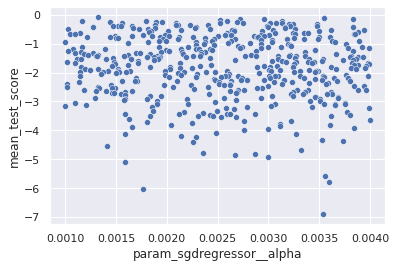

In [28]:
sns.scatterplot(x="param_sgdregressor__alpha", y="mean_test_score", data=df_rs_sgd)

### Grid search

In [29]:
%%time
sgd_gs_result = regressions.algorithms['sgd'].grid_search()

CPU times: user 4.92 s, sys: 7.2 ms, total: 4.92 s
Wall time: 4.94 s


In [30]:
sgd_gs_result.best_params_

{'sgdregressor__alpha': 0.003,
 'sgdregressor__epsilon': 2.5,
 'sgdregressor__loss': 'huber'}

In [31]:
df_gs_sgd = pd.DataFrame(sgd_gs_result.cv_results_).sort_values('rank_test_score')
df_gs_sgd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdregressor__alpha,param_sgdregressor__epsilon,param_sgdregressor__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
48,0.011857,0.000485,0.002800,0.000025,0.003,2.5,huber,"{'sgdregressor__alpha': 0.003, 'sgdregressor__...",-0.051922,-0.279524,-0.187764,-0.203948,-0.018135,-0.148259,0.098087,1
16,0.010297,0.000301,0.002761,0.000011,0.0015,3.5,huber,"{'sgdregressor__alpha': 0.0015, 'sgdregressor_...",-0.256011,-0.431627,-0.886235,-0.276184,-0.022573,-0.374526,0.287296,2
52,0.010411,0.000578,0.002807,0.000042,0.003,3.5,huber,"{'sgdregressor__alpha': 0.003, 'sgdregressor__...",-0.586720,-0.955662,-0.545622,-0.023418,-0.027095,-0.427704,0.358292,3
2,0.011127,0.000347,0.002816,0.000011,0.001,3,huber,"{'sgdregressor__alpha': 0.001, 'sgdregressor__...",-0.111179,-0.094509,-2.113469,-0.044195,-0.032154,-0.479101,0.817721,4
24,0.011750,0.000343,0.002794,0.000018,0.002,2.5,huber,"{'sgdregressor__alpha': 0.002, 'sgdregressor__...",-0.037685,-0.977073,-1.452777,-0.054595,-0.034584,-0.511343,0.593881,5


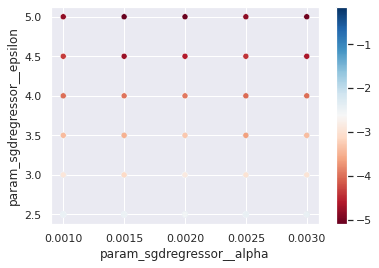

In [32]:
plot_result(df_gs_sgd, 'mean_test_score', 'param_sgdregressor__alpha', 'param_sgdregressor__epsilon')

### Train with best parameters

In [33]:
%%time
regressions.algorithms['sgd'].best_fit()

CPU times: user 15.4 ms, sys: 4.01 ms, total: 19.4 ms
Wall time: 23.6 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.001, epsilon=2.5,
                              loss='epsilon_insensitive'))])

## Model 5: Relevance Vector Regression

An alternative to the SVR is the Relevance Vector Machine, also used by Vandenbosch (2018). This isn't included in sklearn, but there are two packages called 'scikit-rvm' and 'sklearn-rvm' using the sklearn API that has implemented this.

### Randomized search

Inschatting tijd, mijn computer:
    
- 4 min voor een RVR (1 configuratie)
- RandomizedSearch: 250 iteraties, 5 folds per iteratie = 1250
- 1250 RVR * 4 min = 84 uur (Schatting met mijn 2 cores)

Memory usage:
- 4 GB per core?

In [34]:
%%time
emrvr_result = regressions.algorithms['emrvr'].fit()

/home/cmoore/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 458, in predict
    return self.steps[-1][1].predict(X

CPU times: user 281 ms, sys: 1.27 ms, total: 283 ms
Wall time: 5.72 s


/home/cmoore/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/cmoore/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 458, in predict
    return self.steps[-1][1].predict(X

In [35]:
emrvr_result.best_params_

{'emrvr__degree': 6,
 'emrvr__epsilon': 4.004376262779465,
 'emrvr__gamma': 0.006012448978729756,
 'emrvr__kernel': 'poly'}

### Train on best SVR parameters

In [36]:
%%time
regressions.algorithms['emrvr'].best_fit()

CPU times: user 12.4 ms, sys: 7 µs, total: 12.4 ms
Wall time: 16.1 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('emrvr',
                 EMRVR(epsilon=1.5, gamma=0.0022222222222222222,
                       init_alpha=9.802960494069208e-05))])

### Grid search

Inschatting tijd, mijn computer: 

- 4 min voor 1 RVR (1 configuratie). 
- GridSearch: 50 configuraties, 5 folds per configuratie = 250
- 250 RVR * 4 min = 17 uur (Schatting met mijn 2 cores)

<div class="alert alert-block alert-warning">
    TODO(wvxvw): The code below seems bogus.
    The pipeline uses unexpected kernel.
    I don't know why it does this. Need more info
</div>

In [37]:
from sklearn_rvm import EMRVR

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

parameters = {'svr__epsilon': [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8],
              'svr__gamma': ['scale', 'auto', 0.0015]
}

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True, kernel='rbf'))

RVR_gridsearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=10)

RVR_gridsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'RVR_gridsearch.joblib')
dump(RVR_gridsearch, output_file)

NameError: name 'SVR' is not defined

In [ ]:
RVR_gridsearch.best_params_

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    RVR_gridsearch
except:
    RVR_gridsearch = load(os.path.join(PATH_MODELS, 'RVR_gridsearch.joblib'))    

# Update verbosity
RVR_gridsearch.verbose = 0

# R2
score = RVR_gridsearch.score(X_test, y_test)

# MSE
predictions = RVR_gridsearch.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Relevance Vector Regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

del rvr_reg

In [38]:
regressions.algorithms['emrvr'].predict()

ValueError: Found array with 0 sample(s) (shape=(0, 450)) while a minimum of 1 is required by check_pairwise_arrays.

In [39]:
regressions.algorithms['sgd'].predict()

(-0.801028431649742, 15.072938753657624, 11.990667926767836)

## Model 6: Neural network

In [40]:
optimizer = NnOptimizer(rloader, epochs=20)

### Plot NN training history

In [41]:
def plot_loss(history):
    """ Plots the MSE, RMSE, and MAE loss for the training and validation data over time """
    
    %matplotlib inline
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12), dpi=200)

    ax1.plot(history.history['loss'], label='training data')  
    min_loss = min(history.history['val_loss'])
    val_plot1 = ax1.plot(history.history['val_loss'], label='validation data')
    ax1.axhline(y = min_loss, color = val_plot1[0].get_color(), linestyle='--') 
    x0,x1 = ax1.get_xlim()
    ax1.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax1.set_title('MSE loss')
    ax1.set_ylabel('MSE')
    ax1.set_xlabel('epochs')
    ax1.legend()

    ax2.plot(history.history['root_mean_squared_error'], label='training data')
    min_loss = min(history.history['val_root_mean_squared_error'])
    val_plot2 = ax2.plot(history.history['val_root_mean_squared_error'], label='validation data')
    ax2.axhline(y = min_loss, color=val_plot2[0].get_color(), linestyle='--') 
    x0,x1 = ax2.get_xlim()
    ax2.text(x1, min_loss, '{:.2f}'.format(min_loss), ha='left', va='center')
    ax2.set_title('RMSE loss')
    ax2.set_ylabel('RMSE')
    ax2.set_xlabel('epochs')
    ax2.legend()
    
    ax3.plot(history.history['mean_absolute_error'], label='training data')    
    min_loss = min(history.history['val_mean_absolute_error'])
    val_plot3 = ax3.plot(history.history['val_mean_absolute_error'], label='validation data')
    ax3.axhline(y=min_loss, color=val_plot3[0].get_color(), linestyle='--') 
    x0,x1 = ax3.get_xlim()
    ax3.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax3.set_title('MAE loss')
    ax3.set_ylabel('MAE')
    ax3.set_xlabel('epochs')
    ax3.legend()

In [42]:
# This has to be repeated multiple times because the output from optimizer prevents proper display of the plot
history = optimizer.fit_model(0)

2022-08-13 16:06:14.793463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-13 16:06:14.793489: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-13 16:06:14.793508: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupytersunday): /proc/driver/nvidia/version does not exist
2022-08-13 16:06:14.795973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               230912    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [ ]:
plot_loss(history)

In [ ]:
history = optimizer.fit_model(1)

In [ ]:
plot_loss(history)

In [ ]:
history = optimizer.fit_model(2)

In [ ]:
plot_loss(history)

In [ ]:
history = optimizer.fit_model(3)

In [ ]:
plot_loss(history)

In [ ]:
history = optimizer.fit_model(4)

In [ ]:
plot_loss(history)

In [ ]:
for i, p in enumerate(optimizer.optimization_params):
    prediction, rmse, mae = optimizer.predict(i)
    print('\n'.join((
        f'Performance of simple FC neural network regressor #{i} ({p}):',
        f'  RMSE: {rmse}',
        f'  MAE: {mae}.',
    )))